In [6]:
# 📦 Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [7]:
# 📥 Load data
train_path = '/kaggle/input/capstone-match-pred/PremMatches2(2024-2019).csv'
test_path = '/kaggle/input/capstone-match-pred/PremMatches(2021-2022).csv'
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)
df = pd.concat([train_df, test_df])
df["date"] = pd.to_datetime(df["date"])

# 🔍 Data Exploration
print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum().sort_values(ascending=False)[:10]}")

# 🧐 Class distribution
result_counts = df["result"].value_counts()
print(f"\nResult distribution:\n{result_counts}")
print(f"Result percentages:\n{result_counts / len(df) * 100}")


Dataset shape: (5189, 28)
Missing values:
notes            5189
attendance       1578
opp formation    1389
dist                2
date                0
formation           0
season              0
pkatt               0
pk                  0
fk                  0
dtype: int64

Result distribution:
result
L    2016
W    1994
D    1179
Name: count, dtype: int64
Result percentages:
result
L    38.851416
W    38.427443
D    22.721141
Name: count, dtype: float64


In [11]:
# 🔣 Encoding & time features
df["venue_code"] = df["venue"].astype("category").cat.codes
df["result_code"] = df["result"].astype("category").cat.codes
df["opp_code"] = df["opponent"].astype("category").cat.codes
df["day_code"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["season"] = df["date"].dt.year
df["is_weekend"] = df["day_code"].isin([5, 6]).astype(int)
df["hour"] = pd.to_numeric(df["time"].str.extract(r'(\d+)', expand=False), errors='coerce')
df["is_evening"] = (df["hour"] >= 17).astype(int)
df["formation_clean"] = df["formation"].str.replace("◆", "", regex=False)
df["defensive_line"] = df["formation_clean"].str.extract(r'^(\d)').astype(float)
df["formation_code"] = pd.to_numeric(df["formation_clean"].str.replace("-", "", regex=True), errors='coerce')

# Team strength indicators
def create_advanced_features(df):
    team_strength = {}
    for season in df["season"].unique():
        season_data = df[df["season"] == season]
        for team in season_data["team"].unique():
            team_data = season_data[season_data["team"] == team]
            wins = sum(team_data["result_code"] == 2)
            games = len(team_data)
            if games > 0:
                team_strength[f"{team}_{season}"] = wins / games
    df["team_strength"] = df.apply(lambda x: team_strength.get(f"{x['team']}_{x['season']}", 0.5), axis=1)
    df["opponent_strength"] = df.apply(lambda x: team_strength.get(f"{x['opponent']}_{x['season']}", 0.5), axis=1)
    return df

df = create_advanced_features(df)


In [12]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt", "poss", "xg", "xga"]

def rolling_averages_advanced(group, cols, window_sizes=[5, 10]):
    group = group.sort_values("date")
    for window in window_sizes:
        rolling_stats = group[cols].rolling(window, closed='left').mean()
        group[[f"{c}_rolling_{window}" for c in cols]] = rolling_stats
        group[f"goal_diff_rolling_{window}"] = group["gf"].rolling(window, closed='left').sum() - group["ga"].rolling(window, closed='left').sum()
        point_map = {2: 3, 1: 1, 0: 0}
        group[f"form_points_{window}"] = group["result_code"].map(point_map).rolling(window, closed='left').sum()
    
    group["days_since_last_matchup"] = np.nan
    group["last_result_vs_opp"] = np.nan
    group["h2h_win_pct"] = 0.5
    
    h2h_records = {}
    for i in range(len(group)):
        curr_row = group.iloc[i]
        opponent = curr_row["opponent"]
        match_date = curr_row["date"]
        key = f"{curr_row['team']}_{opponent}"
        if key not in h2h_records:
            h2h_records[key] = {"last_date": None, "last_result": None, "wins": 0, "total": 0}
        if h2h_records[key]["last_date"] is not None:
            group.at[i, "days_since_last_matchup"] = (match_date - h2h_records[key]["last_date"]).days
            group.at[i, "last_result_vs_opp"] = h2h_records[key]["last_result"]
            if h2h_records[key]["total"] > 0:
                group.at[i, "h2h_win_pct"] = h2h_records[key]["wins"] / h2h_records[key]["total"]
        if i > 0:
            result = curr_row["result_code"]
            if result == 2:
                h2h_records[key]["wins"] += 1
            h2h_records[key]["total"] += 1
        h2h_records[key]["last_date"] = match_date
        h2h_records[key]["last_result"] = curr_row["result_code"]
    return group

df = df.groupby("team").apply(lambda x: rolling_averages_advanced(x, cols=cols)).reset_index(drop=True)

# Fill missing rolling stats
for col in df.columns:
    if '_rolling_' in col or col in ['days_since_last_matchup', 'last_result_vs_opp', 'h2h_win_pct']:
        df[col] = df[col].fillna(df.groupby('team')[col].transform('mean')).fillna(df[col].median())


In [14]:
# Game importance
def advanced_game_importance(row):
    importance = 0
    if row["date"].month in [4, 5]: importance += 2
    derby_teams = {
        "Arsenal": ["Tottenham", "Chelsea"],
        "Man City": ["Man United", "Liverpool"],
        "Liverpool": ["Everton", "Man United"],
        "Tottenham": ["Arsenal", "Chelsea"],
        "Chelsea": ["Arsenal", "Tottenham"],
        "Man United": ["Man City", "Liverpool"],
        "Everton": ["Liverpool"],
        "Newcastle": ["Sunderland"],
    }
    if row["opponent"] in derby_teams.get(row["team"], []): importance += 2
    if row["team_strength"] > 0.6 or row["team_strength"] < 0.3: importance += 1
    return importance

df["game_importance"] = df.apply(advanced_game_importance, axis=1)

# Features
numeric_features = [
    "hour", "day_code", "month", "defensive_line", "is_weekend", "is_evening",
    "team_strength", "opponent_strength", "game_importance"
]
numeric_features += [c for c in df.columns if "_rolling_" in c or c in ["days_since_last_matchup", "h2h_win_pct"]]
categorical_features = ["venue_code", "opp_code"]
features = numeric_features + categorical_features

# Drop rows with missing
df = df.dropna(subset=features + ["result_code"])

# Train-test split
train_df = df[df["date"] < "2023-07-01"]
test_df = df[df["date"] >= "2023-07-01"]
X_train = train_df[features]
y_train = train_df["result_code"]
X_test = test_df[features]
y_test = test_df["result_code"]


In [15]:
# Pipeline setup
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

class_counts = y_train.value_counts()
scale_pos_weight = class_counts.max() / class_counts.min()

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Grid search
param_grid = {
    'classifier__n_estimators': [200],
    'classifier__max_depth': [5],
    'classifier__learning_rate': [0.05],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
    'classifier__min_child_weight': [2],
    'classifier__gamma': [0.1],
    'classifier__reg_alpha': [0.1],
    'classifier__reg_lambda': [1],
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")

# Evaluation
print("\n📘 Training Report:")
print(classification_report(y_train, best_model.predict(X_train), zero_division=0))
print("\n📗 Test Report:")
print(classification_report(y_test, best_model.predict(X_test), zero_division=0))
print(f"\n🎯 Training Accuracy: {best_model.score(X_train, y_train):.2f}")
print(f"🎯 Test Accuracy: {best_model.score(X_test, y_test):.2f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:00:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:00:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:00:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.8}

📘 Training Report:
              precision    recall  f1-score   support

         0.0       0.98      0.57      0.72      1015
         1.0       0.79      0.89      0.84      1718
         2.0       0.79      0.89      0.84      1696

    accuracy                           0.82      4429
   macro avg       0.85      0.78      0.80      4429
weighted avg       0.84      0.82      0.81      4429


📗 Test Report:
              precision    recall  f1-score   support

         0.0       0.25      0.05      0.08       164
         1.0       0.56      0.76      0.64       298
         2.0       0.63      0.67      0.65       298

    accuracy                           0.57       760
   macro a

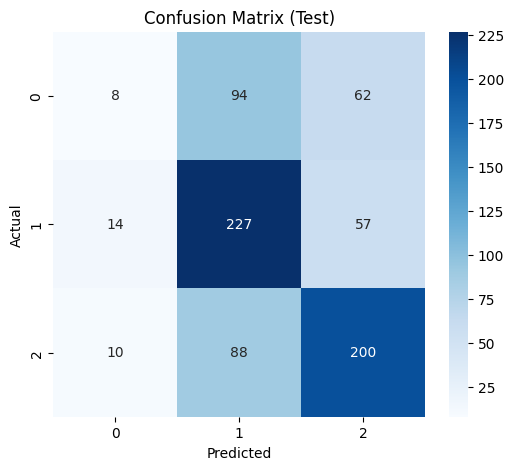

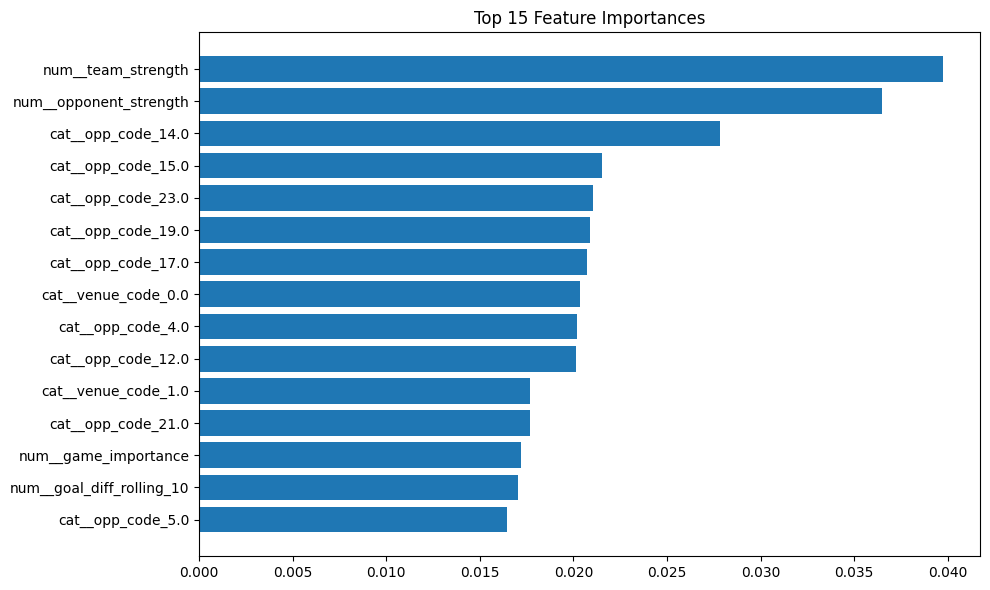

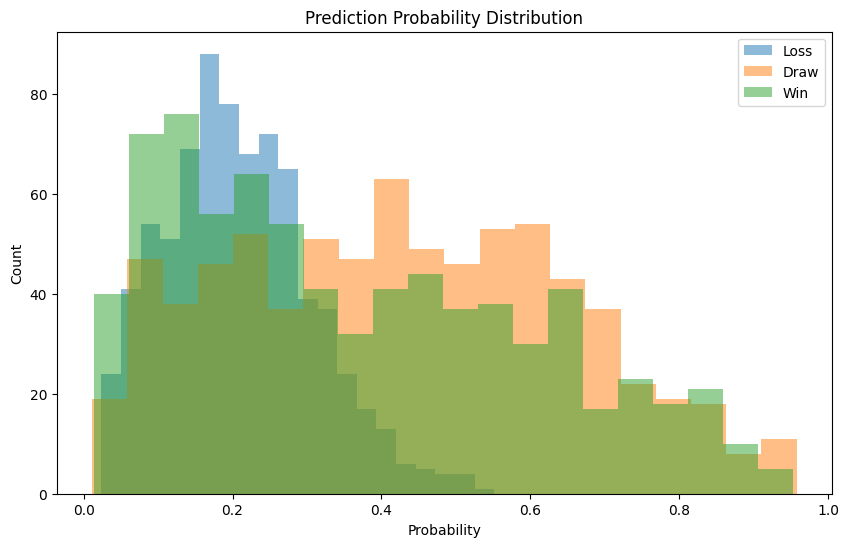

In [16]:
# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importances
try:
    importances = best_model.named_steps['classifier'].feature_importances_
    input_features = best_model.named_steps['preprocessor'].get_feature_names_out()
    indices = np.argsort(importances)[::-1][:15]
    plt.figure(figsize=(10, 6))
    plt.title('Top 15 Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [input_features[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importances: {e}")

# Prediction probabilities
try:
    proba = best_model.predict_proba(X_test)
    plt.figure(figsize=(10, 6))
    plt.hist(proba[:, 0], alpha=0.5, bins=20, label='Loss')
    plt.hist(proba[:, 1], alpha=0.5, bins=20, label='Draw')
    plt.hist(proba[:, 2], alpha=0.5, bins=20, label='Win')
    plt.title("Prediction Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Could not plot prediction probabilities: {e}")
